# ssh_model evaluation 3

In [1]:
import warnings
warnings.filterwarnings('ignore')  #suppress some warnings about future code changes

import pandas as pd
import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html
#import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal as sg  #Package for signal analysis
import scipy.ndimage as si #Another package for signal analysis
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
from scipy import stats    #Used for 2D binned statistics
from mpl_toolkits.axes_grid1 import make_axes_locatable #For plotting interior colobars
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
import pyicon as pyic
import glob, os        
#import spectrum

#from scipy import signal, ndimage
from scipy import fft as spfft
from scipy.fft import fft 
from pathlib import Path


-----calc
sys glob os
numpy
netcdf
Done modules calc.
-----calc_xr
sys glob os
numpy
netcdf
xarray
Done modules calc.
-----tb
sys
json
numpy
scipy
netcdf datetime
matplotlib
mybreak
pnadas
xarray
done xarray
-----IconData
-----plotting
-----view
-----calc
-----calc_xr
-----tb
-----IconData
-----plotting
-----view
-----quickplots
-----quickplots


#cluster
import datetime
import multiprocessing
from dask_jobqueue import SLURMCluster # Setting up distributed memories via slurm
from dask.utils import format_bytes
from dask.distributed import Client, LocalCluster, progress # Libaray to orchestrate distributed resources

from tempfile import NamedTemporaryFile, TemporaryDirectory # Creating temporary Files/Dirs
from getpass import getuser # Libaray to copy things
from pathlib import Path # Object oriented libary to deal with paths

## Start cluster

!echo $HOSTNAME

# Set some user specific variables
account_name = 'mh0033' # Account that is going to be 'charged' fore the computation
queue = 'gpu' # Name of the partition we want to use
job_name = 'PostProc' # Job name that is submitted via sbatch
memory = "200GiB" # Max memory per node that is going to be used - this depends on the partition
cores = 24 # Max number of cores per task that are reserved - also partition dependend
walltime = '8:00:00' # Walltime - also partition dependent

scratch_dir = Path('/scratch') / getuser()[0] / getuser() # Define the users scratch dir
# Create a temp directory where the output of distributed cluster will be written to, after this notebook
# is closed the temp directory will be closed
dask_tmp_dir = TemporaryDirectory(dir=scratch_dir, prefix=job_name)
cluster = SLURMCluster(memory=memory,
                       cores=cores,
                       project=account_name,
                       walltime=walltime,
                       queue=queue,
                       name=job_name,
                       scheduler_options={'dashboard_address': ':8989'},
                       local_directory=dask_tmp_dir.name,
                       job_extra=[f'-J {job_name}', 
                                  f'-D {dask_tmp_dir.name}',
                                  f'--begin=now',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o',
                                  f'--output={dask_tmp_dir.name}/LOG_cluster.%j.o'
                                 ],
                       interface='ib0')

print(cluster.job_script())

cluster.scale(jobs=2)
cluster

! squeue -u $USER

client = Client(cluster)
client

In [2]:
# convert to meter
r = 6371000
const_lat = 32 # latitude of section
latitude = np.linspace(0,90,90)
delta = 2*np.pi*r/360*np.cos(latitude/90* np.pi/2)
print('distance of one degree in meter at equator', delta[0])
print('distance of one degree in meter at section', delta[const_lat])

distance of one degree in meter at equator 111194.92664455873
distance of one degree in meter at section 93927.02124530253


In [3]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

## aviso ssh data

path_data = '/pool/data/ICDC/ocean/aviso_ssh/DATA/2010/'
fname = 'dt_global_twosat_phy_l4_20191228_vDT2018.nc' #last
#### flist
search_str = f'dt_global_twosat_phy_l4_2010*.nc' 
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()
flist = flist[:90]

ds = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1))
longi = ds.longitude - 360 #cheap fix since NA is focus region
ds = ds.assign_coords(longitude = longi)

In [4]:
# /work/mh0033/from_Mistral/mh0033/u241317/satellite/ssh/ssh_sat_temp
search_str = f'dt_global_twosat_phy_l4_*.nc' 
month = '01'
path_data = f'/pool/data/ICDC/ocean/aviso_ssh/DATA/2010/{month}/'
path_data = f'/work/mh0033/from_Mistral/mh0033/u241317/satellite/ssh/ssh_sat_temp/{month}/'
flist1      = np.array(glob.glob(path_data+search_str))
flist1.sort()
month = '02'
path_data = f'/pool/data/ICDC/ocean/aviso_ssh/DATA/2010/{month}/'
path_data = f'/work/mh0033/from_Mistral/mh0033/u241317/satellite/ssh/ssh_sat_temp/{month}/'
flist2      = np.array(glob.glob(path_data+search_str))
flist2.sort()
month = '03'
path_data = f'/pool/data/ICDC/ocean/aviso_ssh/DATA/2010/{month}/'
path_data = f'/work/mh0033/from_Mistral/mh0033/u241317/satellite/ssh/ssh_sat_temp/{month}/'
flist3      = np.array(glob.glob(path_data+search_str))
flist3.sort()

flist = [*flist1, *flist2, *flist3]
flist.sort()

ds = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1))
#longi = ds.longitude - 360 #cheap fix since NA is focus region
#ds = ds.assign_coords(longitude = longi)

lon = [-80, -30]
lat = [31.8, 32]
ds_section = ds.where((ds.latitude > lat[0]) & (ds.latitude < lat[1]) & (ds.longitude > lon[0]) & (ds.longitude < lon[1]), drop=True)
ds_section

fig = plt.figure(figsize=(12,6))
ds.isel(time=0).sla.plot()

In [5]:
lon = [-90, -20]
lat = [20, 60]
ds_search = ds.where((ds.latitude > lat[0]) & (ds.latitude < lat[1]) & (ds.longitude > lon[0]) & (ds.longitude < lon[1]), drop=True)
ds_search

<xarray.Dataset>
Dimensions:         (time: 90, latitude: 160, longitude: 280, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2010-03-31
  * latitude        (latitude) float32 20.12 20.38 20.62 ... 59.38 59.62 59.88
  * longitude       (longitude) float32 -89.88 -89.62 -89.38 ... -20.38 -20.12
  * nv              (nv) int32 0 1
Data variables: (12/14)
    crs             (time, latitude, longitude) float64 -2.147e+09 ... -2.147...
    lat_bnds        (time, latitude, nv, longitude) float32 dask.array<chunksize=(1, 160, 2, 280), meta=np.ndarray>
    lon_bnds        (time, longitude, nv, latitude) float32 dask.array<chunksize=(1, 280, 2, 160), meta=np.ndarray>
    sla             (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 280), meta=np.ndarray>
    err_sla         (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 280), meta=np.ndarray>
    ugosa           (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 280), meta=np.ndarray>
    ...              ...
    err_vgosa       (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 280), meta=np.ndarray>
    adt             (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 280), meta=np.ndarray>
    ugos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 280), meta=np.ndarray>
    vgos            (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 280), meta=np.ndarray>
    tpa_correction  (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 280), meta=np.ndarray>
    flag_ice        (time, latitude, longitude) float64 dask.array<chunksize=(1, 160, 280), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2010-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2009-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

fig = plt.figure(figsize=(12,6))
ds_search.isel(time=0).adt.plot()

In [86]:
# old
lon1 = -75, - 50
lon2 = -50, -25
lati = 24.8, 25.2
lati = lati - np.ones(2)*3
Lat = np.zeros((15, 2))
Lon = np.zeros((15, 2))
for ii in np.arange(15):
    lati += np.ones(2)*3
    if ii == 5: 
        lati = 24.8, 25.2
    Lat[ii,:] = lati
    if ii < 5:
        Lon[ii,:] = lon1
    else:
        Lon[ii,:] = lon2
        

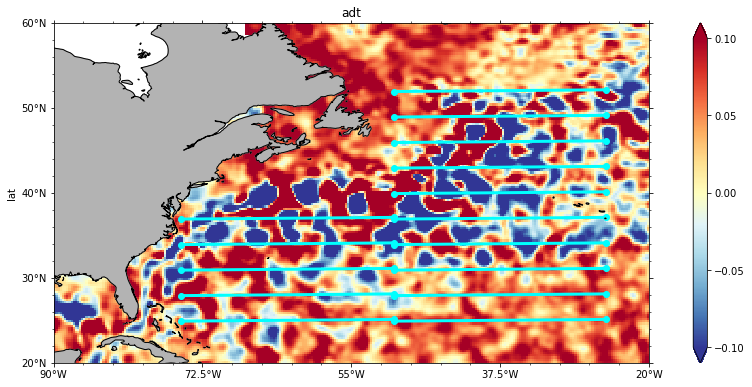

In [66]:
lon_reg = [-90, -20]
lat_reg = [20, 60]

data = ds_search.isel(time=0).sla
lon = ds_search.longitude
lat = ds_search.latitude

hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.51, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, data.data, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False)

for ii in np.arange(15):
    ax.plot(Lon[ii,:], Lat[ii,:], transform=ccrs_proj, color='aqua', linewidth=3, marker='o', markersize=6)

ax.set_title('adt')
#ax.set_xlabel('lon')
ax.set_ylabel('lat')
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)

#plt.savefig('../images/ssh_slice')

In [51]:
#5_2
lon1 = -75, - 50
#lati = 24.8, 25.2
lati = 29.8, 30.2
lati = lati - np.ones(2)
n = 10
Lat = np.zeros((n, 2))
Lon = np.zeros((n, 2))
for ii in np.arange(n):
    lati += np.ones(2)*0.5
    Lat[ii,:] = lati
    Lon[ii,:] = lon1
        

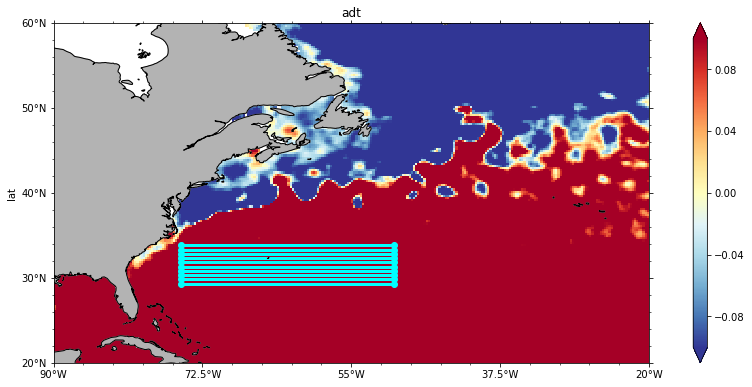

In [52]:
lon_reg = [-90, -20]
lat_reg = [20, 60]

data = ds_search.isel(time=0).adt
lon = ds_search.longitude
lat = ds_search.latitude

hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=0.51, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
pyic.shade(lon, lat, data.data, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False)

for ii in np.arange(n):
    ax.plot(Lon[ii,:], (Lat[ii,0], Lat[ii,0]), transform=ccrs_proj, color='aqua', linewidth=3, marker='o', markersize=6)

ax.set_title('adt')
#ax.set_xlabel('lon')
ax.set_ylabel('lat')
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)

#plt.savefig('../images/ssh_slice5_2')

### satellite

In [54]:
%%time
for kk in np.arange(n):
    print(kk)
    lat = Lat[kk,:]
    lon = Lon[kk,:]
    ds_section = ds.where((ds.latitude > lat[0]) & (ds.latitude < lat[1]) & (ds.longitude > lon[0]) & (ds.longitude < lon[1]), drop=True)
    ds_lat = int(ds_section.latitude[0].data)
    ds_section = ds_section.isel(latitude=0)
    dm_sat = (ds_section.longitude[1] - ds_section.longitude[0]) * delta[ds_lat]
    dm_sat = dm_sat.data
    ###############################################################
    # satellite
    ds_size = int(ds_section.longitude.size /2) +1
    iii = 0
    A_sat = np.zeros((90,ds_size))
    for ii in np.arange(90)[::1]:
        t_sat = ds_section.time[ii].data
        y = ds_section.isel(time=ii).adt
        cv = y.data.compute() 
        nans, x= nan_helper(cv) 
        cv[nans]= np.interp(x(nans), x(~nans), cv[~nans])
        f, S = sg.periodogram(cv-np.nanmean(cv), fs=1/dm_sat)
        S = S.squeeze()
        A_sat[iii,:] = S
        iii += 1
    f_sat = f
    A_sat_mean = np.mean(A_sat, axis=0)
    std_sat = np.std(A_sat, axis=0)
    np.save(f'data/satellite_sections/10_3/data_sat_{Lat[kk,0]}_{Lon[kk,0]}', [A_sat, f_sat, dm_sat, A_sat_mean, std_sat])


0
1
2
3
4
5
6
7
8
9
CPU times: user 11.4 s, sys: 2.72 s, total: 14.1 s
Wall time: 22.4 s


powerlaw = lambda x, amp, index: amp * (x**index)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
l=2.5

[A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load('data/satellite_sections/data_sat_30.8_-75.0.npy',allow_pickle=True)
plt.loglog(f_sat, A_sat_mean, label='sat_adt_mean  -30.8', linewidth=2)

[A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load('data/satellite_sections/data_sat_31.8_-75.0.npy',allow_pickle=True)
plt.loglog(f_sat, A_sat_mean, label='sat_adt_mean  -31.8', linewidth=2)

[A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load('data/satellite_sections/data_sat_32.8_-75.0.npy',allow_pickle=True)
plt.loglog(f_sat, A_sat_mean, label='sat_adt_mean -32.8', linewidth=2)


A_sat = np.load('data/one_slice/A_sat.npy')
f_sat = np.load('data/one_slice/f_sat.npy')
A_sat_mean = np.mean(A_sat, axis=0)
std_sat = np.std(A_sat, axis=0)

plt.loglog(f_sat, A_sat_mean, label='sat_adt_mean old 31.9', linewidth=2)



#####################################################################
x = f_smt
def forward(x):
    return 1 / x / 1000
def inverse(x):
    return 1 / x 
secax = ax.secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel('wavelength in [km]', fontsize=15)

ax.autoscale(enable=True, tight=True)
ax.set_ylim(1, 5e4)
#ax.autoscale(enable=True, tight=True)
#ax.set_xlim(1e-8, 1e-3)
fig.tight_layout()

plt.legend(fontsize=15, loc='lower left')
ax.tick_params(labelsize=15)
secax.tick_params(labelsize=15)
plt.xlabel('Wavenumber (1/m)', fontsize=15)
plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
plt.title('Averaged Spectral Estimates of SSH spatial series',fontsize=15);
#plt.savefig('../images/fft_ssh_spat_sat_smt_adt_Robust_std_s', bbox_inches='tight')

### smt

In [ ]:
#levante /work/mh0287/from_Mistral/mh0287/users/leonidas/icon/ngSMT/results

### load ssh data from smt model

In [55]:
run      = 'ngSMT_tke'
gname = 'smt'
fpath_tgrid  = '/home/mpim/m300602/work/icon/grids/smt/smt_tgrid.nc'

path_grid        = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree     = f'{path_grid}ckdtree/'
fpath_ckdtree    = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'

In [56]:
search_str = f'_h_sp_*.nc' 
month = '01'
path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
path_data = f'/work/mh0287/from_Mistral/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
flist1      = np.array(glob.glob(path_data+search_str))
flist1.sort()
month = '02'
path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
path_data = f'/work/mh0287/from_Mistral/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
flist2      = np.array(glob.glob(path_data+search_str))
flist2.sort()
month = '03'
path_data = f'/mnt/lustre01/work/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
path_data = f'/work/mh0287/from_Mistral/mh0287/users/leonidas/icon/ngSMT/results/2010-{month}/{run}'
flist3      = np.array(glob.glob(path_data+search_str))
flist3.sort()

flist = [*flist1, *flist2, *flist3]
flist.sort()

In [57]:
time0 = np.datetime64('2010-01-09T01:00:00')
dti = pd.date_range(time0, periods=984, freq="2h")
smt = xr.open_mfdataset(flist, combine='nested', concat_dim='time', parallel=True, chunks=dict(time=1))
smt = smt.assign_coords(time=dti)


In [34]:
smt

<xarray.Dataset>
Dimensions:  (time: 984, ncells: 59799625)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-09T01:00:00 ... 2010-03-31T23:00:00
Dimensions without coordinates: ncells
Data variables:
    h_sp     (time, ncells) float32 dask.array<chunksize=(1, 59799625), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.2 (http://mpimet...
    Conventions:          CF-1.6
    number_of_grid_used:  42
    uuidOfHGrid:          0d39853e-c26b-11e9-8454-0b16a6d45f73
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               git@gitlab.dkrz.de:icon/icon-oes.git@e7e7a45736e586...
    history:              /work/mh0287/users/leonidas/icon/icon-oes_ngSMT/int...
    references:           see MPIM/DWD publications
    comment:              Leonidas Linardakis (m300056) on m20180 (Linux 2.6....

In [32]:
lon1 = -75, - 50
lati = 28.8, 29.2
lati = lati - np.ones(2)
Lat = np.zeros((5, 2))
Lon = np.zeros((5, 2))
for ii in np.arange(5):
    lati += np.ones(2)*1
    Lat[ii,:] = lati
    Lon[ii,:] = lon1

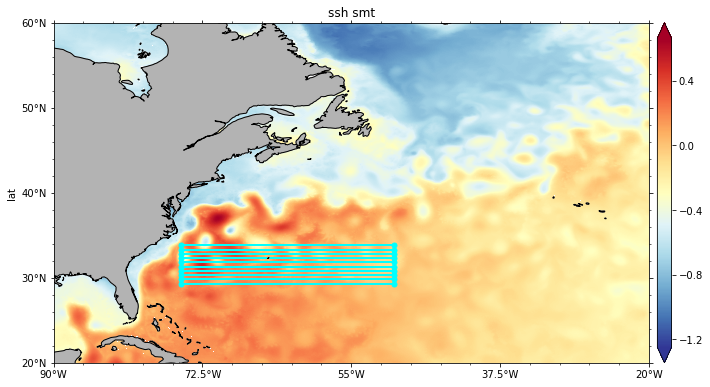

In [58]:
#fpath_ckdtree    = '/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/icon_ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
fpath_ckdtree = '/work/mh0033/from_Mistral/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
lon_reg = [-90, -20]
lat_reg = [20, 60]
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp, fig_size_fac=3, projection=ccrs_proj, axlab_kw=None)
ii=-1
ii+=1; ax=hca[ii]; cax=hcb[ii]
lon, lat, data = pyic.interp_to_rectgrid(smt.isel(time=50).h_sp, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
pyic.shade(lon, lat, data, ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False)

for ii in np.arange(n):
    ax.plot(Lon[ii,:], (Lat[ii,0], Lat[ii,0]), transform=ccrs_proj, color='aqua', linewidth=2, marker='o', markersize=5)

ax.set_title('ssh smt')
#ax.set_xlabel('lon')
ax.set_ylabel('lat')
for ax in hca:
    pyic.plot_settings(ax, xlim=lon_reg, ylim=lat_reg)

#plt.savefig('../images/ssh_slices')
plt.savefig('spectra/10_3/slice_region10_3')

0
section file does not exist
Saving grid file: /scratch/m/m300878/slices/SMT_nps2900_50W29.5N_75W29.5N.nc
max 716.8503483906748 min 550.7860282195877 distance section 809.9950090140394
averaged data saved in data/smt_sections/data_smt_29.3_-75.0
1
section file does not exist
Saving grid file: /scratch/m/m300878/slices/SMT_nps2900_50W30N_75W30N.nc
max 708.9968146751846 min 557.800353366522 distance section 809.9950090140394
averaged data saved in data/smt_sections/data_smt_29.8_-75.0
2
section file does not exist
Saving grid file: /scratch/m/m300878/slices/SMT_nps2900_50W30.5N_75W30.5N.nc
max 701.5608066894822 min 558.0355820631531 distance section 809.9950090140394
averaged data saved in data/smt_sections/data_smt_30.3_-75.0
3
section file does not exist
Saving grid file: /scratch/m/m300878/slices/SMT_nps2900_50W31N_75W31N.nc
max 694.3194161185984 min 557.0534203423309 distance section 809.9950090140394
averaged data saved in data/smt_sections/data_smt_30.8_-75.0
4
section file does n

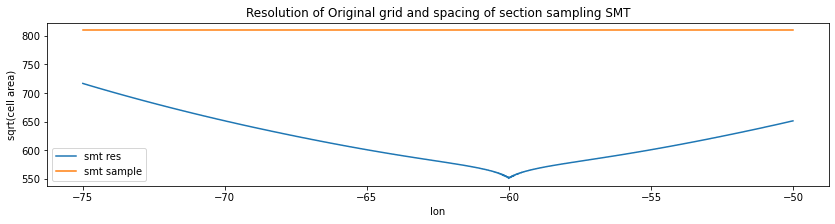

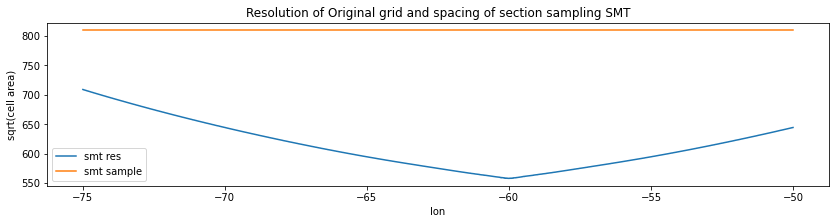

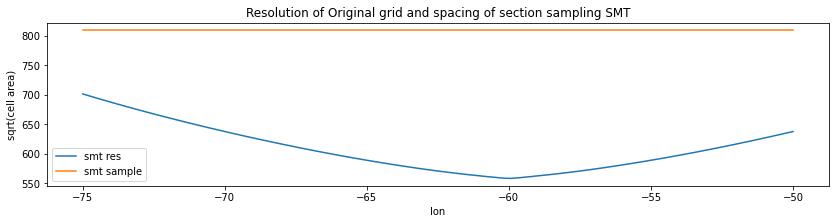

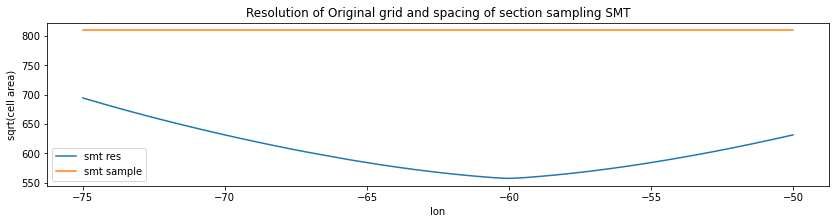

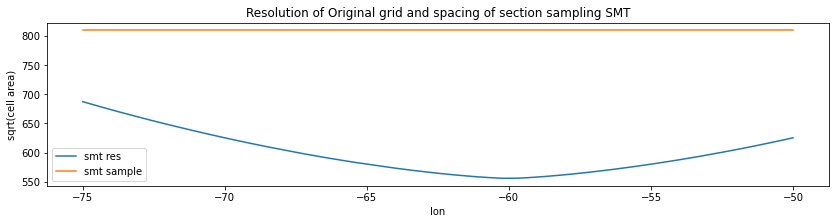

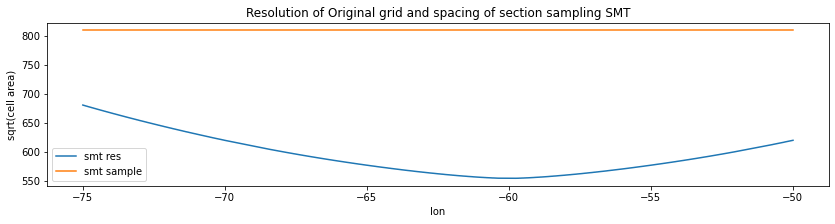

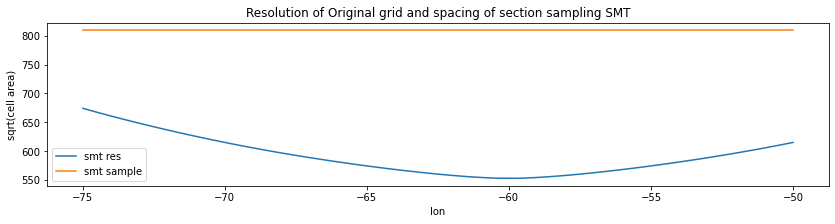

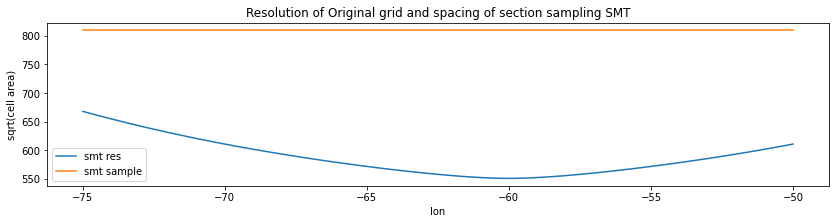

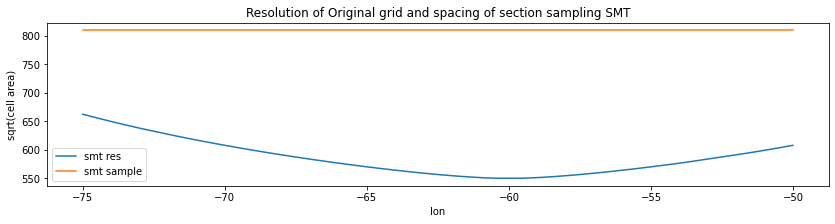

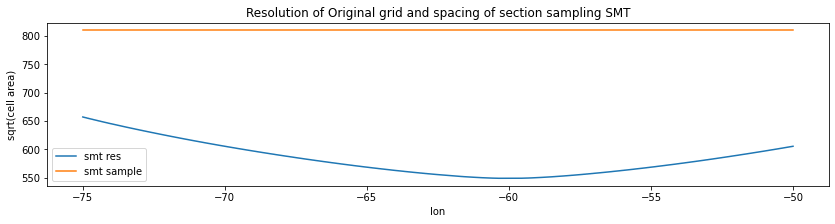

In [59]:
%%time
for kk in np.arange(n):
    print(kk)
    lat = Lat[kk,:]
    lon = Lon[kk,:]
    
    ##############################################################
    ######## calculate nearest neighbour of section
    npoints = 2900
    sname         = 'A'
    tgname        = 'SMT'
    gname         = 'OceanOnly_SubmesoNA_2500m_srtm30'
    path_tgrid    = f'/pool/data/ICON/oes/grids/OceanOnly/'
    fname_tgrid   = f'{gname}.nc'
    path_scratch  = f'/scratch/m/m300878/slices/'
    path_ckdtree  = path_scratch # where grid is stored
    sec_name      = f'SMT_nps{npoints}_{int(np.abs(lon[1]))}W{int(lat[1])}N_{int(np.abs(lon[0]))}W{int(lat[1])}N.npz'
    
    if Path(path_scratch + sec_name ).is_file():
        print ("section File exist")
        data = np.load(path_scratch + sec_name)
        ickdtree = data['ickdtree_c']  
        lon_sec = data['lon_sec']
        lat_sec = data['lat_sec']
    else:
        print ("section file does not exist")
        latii = Lat[kk,:] + 0.2

        dckdtree, ickdtree, lon_sec, lat_sec, dist_sec = pyic.ckdtree_section(p1=[lon[1],latii[0]], p2=[lon[0],latii[0]], npoints=npoints,
                      fname_tgrid  = fname_tgrid,
                      path_tgrid   = path_tgrid,
                      path_ckdtree = path_ckdtree,
                      sname = sname,
                      gname = gname,
                      tgname = tgname,
                      load_egrid=False,
                      load_vgrid=False,
                      )
        # check grid
        sgrid = xr.open_dataset(path_tgrid + fname_tgrid)
        grid  = sgrid.cell_area_p.compute()
        Clon  =  grid.clon * 180/np.pi
        grid  = grid.assign_coords(clon=Clon)
        Clat  =  grid.clat * 180/np.pi
        grid  = grid.assign_coords(clat=Clat)
        grid  = np.sqrt(grid.isel(cell=ickdtree))
        grid  = grid.assign_coords({"lon_sec": ("cell", lon_sec)})
        grid_smt = grid.assign_coords({"lat_sec": ("cell", lat_sec)})
        # section distance
        d_smt_sec = (grid_smt.lon_sec[0] - grid_smt.lon_sec[1]).data *delta[32]
        d_smt_hi_res = grid_smt.min().data
        print('max',grid_smt.max().data, 'min', grid_smt.min().data, 'distance section', d_smt_sec)
    
        # visualize
        fig = plt.figure(figsize=(14,3))
        grid_smt.plot(x="clon", label='smt res')
        plt.plot(lon, ([d_smt_sec, d_smt_sec]), label='smt sample')
        plt.xlabel('lon')
        plt.ylabel('sqrt(cell area)')
        plt.legend()
        plt.title('Resolution of Original grid and spacing of section sampling SMT')
        plt.savefig(f'grid_images/{sec_name}.png')
    
    # select data
    smt_sec = smt.isel(ncells=ickdtree)
    smt_sec = smt_sec.assign_coords({"clon": ("ncells", lon_sec)})
    smt_sec = smt_sec.h_sp
    ########################################################
    
    ds_lat = int(lat_sec[0])
    dm_smt = (smt_sec.clon[0]- smt_sec.clon[1]) * delta[ds_lat]
    dm_smt = dm_smt.data
    ###############################################################
    # smt
    N = 984
    l = 11
    ll = int(N/l) +1
    ds_size = int(smt_sec.clon.size /2) +1
    iii = 0   
    A_smt = np.zeros((ll,ds_size))
    for ii in np.arange(N)[::l]:
        t_smt = smt_sec.time[ii].data
        y = smt_sec.isel(time=ii)
        cv = y.data.compute() 
        f, S = sg.periodogram(cv-np.mean(cv), fs=1/dm_smt)
        S = S.squeeze()
        A_smt[iii,:] = S
        iii += 1
    f_smt = f
    A_smt_mean = np.mean(A_smt, axis=0)
    std_smt = np.std(A_smt, axis=0)
    np.save(f'data/smt_sections/10_3/data_smt_{Lat[kk,0]}_{Lon[kk,0]}', [A_smt, f_smt, dm_smt, A_smt_mean, std_smt])
    print(f'averaged data saved in data/smt_sections/data_smt_{Lat[kk,0]}_{Lon[kk,0]}')



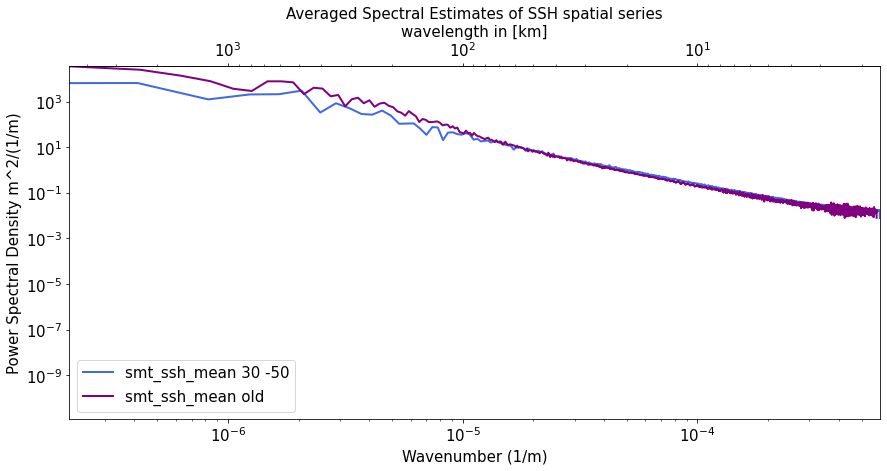

In [85]:
powerlaw = lambda x, amp, index: amp * (x**index)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
l=2.5

[A_smt, f_smt, dm_smt, A_smt_mean, std_smt] = np.load('data/smt_sections/data_smt_28.8_-75.0.npy',allow_pickle=True)

plt.loglog(f_smt, A_smt_mean, label='smt_ssh_mean 30 -50', color='royalblue', linewidth=2)

A_smt = np.load('data/one_slice/A_smt.npy')
f_smt = np.load('data/one_slice/f_smt.npy')
A_smt_mean = np.mean(A_smt, axis=0)
std_smt = np.std(A_smt, axis=0)

plt.loglog(f_smt, A_smt_mean, label='smt_ssh_mean old', color='purple', linewidth=2)


########################################################################
x = f_smt
def forward(x):
    return 1 / x / 1000
def inverse(x):
    return 1 / x 
secax = ax.secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel('wavelength in [km]', fontsize=15)

ax.autoscale(enable=True, tight=True)
#ax.set_ylim(8e-4, 5e4)
#ax.autoscale(enable=True, tight=True)
#ax.set_xlim(1e-6, 1e10)
fig.tight_layout()

plt.legend(fontsize=15, loc='lower left')
ax.tick_params(labelsize=15)
secax.tick_params(labelsize=15)
plt.xlabel('Wavenumber (1/m)', fontsize=15)
plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
plt.title('Averaged Spectral Estimates of SSH spatial series',fontsize=15);
#plt.savefig('../images/fft_ssh_spat_sat_smt_adt_Robust_std_s', bbox_inches='tight')

In [61]:
def plot_spatial_spectra(A_smt_mean, std_smt, A_sat_mean, std_sat, k, figname):
    powerlaw = lambda x, amp, index: amp * (x**index)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    #l=2.5

    # smt
    kernel_size = k
    kernel = np.ones(kernel_size) / kernel_size
    #smean_m_std = A_smt_mean - std_smt #np.abs(A_smt_mean - std_smt)
    smean_m_std = np.abs(A_smt_mean - std_smt)
    smean_m_std = np.convolve(smean_m_std, kernel, mode='same')
    #smean_p_std = A_smt_mean + std_smt#np.abs(A_smt_mean + std_smt)
    smean_p_std = np.abs(A_smt_mean + std_smt)
    smean_p_std = np.convolve(smean_p_std, kernel, mode='same')

    plt.loglog(f_smt, smean_p_std, color='royalblue', linestyle='--',alpha=0.5)
    plt.loglog(f_smt, A_smt_mean, label='smt_ssh_mean', color='royalblue', linewidth=2)
    plt.fill_between(f_smt, A_smt_mean, smean_p_std, color='royalblue', alpha=0.25)
    plt.loglog(f_smt, smean_m_std, linestyle='--',  color='royalblue', alpha=0.5)
    plt.fill_between(f_smt, A_smt_mean, smean_m_std, color='royalblue', alpha=0.25)

    # satellite
    kernel_size = k
    kernel = np.ones(kernel_size) / kernel_size
    mean_m_std = np.abs(A_sat_mean - std_sat)
    mean_m_std = np.convolve(mean_m_std, kernel, mode='same')
    mean_p_std = np.abs(A_sat_mean + std_sat)
    mean_p_std = np.convolve(mean_p_std, kernel, mode='same')

    plt.loglog(f_sat, mean_p_std, color='tomato', linestyle='--', alpha=0.5)
    plt.loglog(f_sat, A_sat_mean, label='sat_adt_mean', color='tomato', linewidth=2)
    plt.fill_between(f_sat, A_sat_mean, mean_p_std, color='wheat', alpha=0.5)
    plt.loglog(f_sat, mean_m_std, linestyle='--',  color='tomato', alpha=0.5)
    plt.fill_between(f_sat, A_sat_mean, mean_m_std, color='wheat', alpha=0.5)

    #####################
    fx = np.linspace(1e-4,5e-4,100)
    pp = 10000
    y2 = pp* 3e-9*np.power(fx, (-2))
    y3 = pp* 1e-13*np.power(fx, (-3))
    y5 = pp* 1e-7*np.power(fx, (-5/3))

    plt.loglog(fx,y3, label='slope -3')
    plt.loglog(fx,y5, label='slope -5/3')

    # slope satellite
    xdata = f_sat[8:]
    ydata = A_sat_mean[8:]
    logx = np.log10(xdata)
    logy = np.log10(ydata)
    res = stats.linregress(logx, logy)
    index = res.slope
    amp = 10**res.intercept
    plt.plot(xdata, powerlaw(xdata, amp, index),linewidth=3, linestyle='dashed', color="limegreen")  
    plt.plot(fx, powerlaw(fx, pp*amp, index), linestyle='dashed', color="limegreen", label=f'slope {index:3.3}') 


    # slope smt
    xdata = f_smt[50:]
    ydata = A_smt_mean[50:]
    logx = np.log10(xdata)
    logy = np.log10(ydata)
    res = stats.linregress(logx, logy)
    index = res.slope
    amp = 10**res.intercept
    plt.plot(xdata, powerlaw(xdata, amp, index),linewidth=3, linestyle='dashed', color="gold")  
    plt.plot(fx, powerlaw(fx, 5*pp*amp, index), linestyle='dashed', color="gold", label=f'slope {index:3.3}') 

    # slope smt
    xdata = f_smt[8:50]
    ydata = A_smt_mean[8:50]
    logx = np.log10(xdata)
    logy = np.log10(ydata)
    res = stats.linregress(logx, logy)
    index = res.slope
    amp = 10**res.intercept
    plt.plot(xdata, powerlaw(xdata, amp, index), linewidth=4, linestyle='--', color="aqua")  
    plt.plot(fx, powerlaw(fx, pp*amp, index), linewidth=2, linestyle='--', color="aqua", label=f'slope {index:3.3}') 

    x = f_smt
    def forward(x):
        return 1 / x / 1000
    def inverse(x):
        return 1 / x 
    secax = ax.secondary_xaxis('top', functions=(forward, inverse))
    secax.set_xlabel('wavelength in [km]', fontsize=15)

    ax.autoscale(enable=True, tight=True)
    ax.set_ylim(8e-4, 5e4)
    #ax.autoscale(enable=True, tight=True)
    #ax.set_xlim(1e-6, 1e10)
    fig.tight_layout()

    plt.legend(fontsize=15, loc='lower left')
    ax.tick_params(labelsize=15)
    secax.tick_params(labelsize=15)
    plt.xlabel('Wavenumber (1/m)', fontsize=15)
    plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
    plt.title(f'Averaged Spectral Estimates of SSH {figname}',fontsize=15);
    plt.savefig(f'spectra/10_3/spatil_spectra_{figname}.png', bbox_inches='tight')

In [56]:
pp = '/scratch/m/m300878/slices/SMT_nps2900_50W33.25N_75W33.25N.nc'
Path( pp).is_file()

True

In [57]:
sec_name = f'{path_scratch}data_smt_{Lat[kk,0]}_{Lon[kk,0]}.nc'

NameError: name 'Lat' is not defined

In [24]:
print('plot temporal averaged and temporal + spatial averaged spectra')
# plot each section
search_str = f'data_sat*.npy' 
#path_data = f'data/satellite_sections/10_3/'
flist      = np.array(glob.glob(path_dat+search_str))
flist.sort()
sat_sections = flist 
search_str = f'data_smt*.npy' 
#path_data = f'data/smt_sections/10_3/'
flist      = np.array(glob.glob(path_dat+search_str))
flist.sort()
smt_sections = flist

plot temporal averaged and temporal + spatial averaged spectra


In [28]:
if True == False:
    print(flist)
else:
    print('false')

false


# test

In [51]:
import scipy

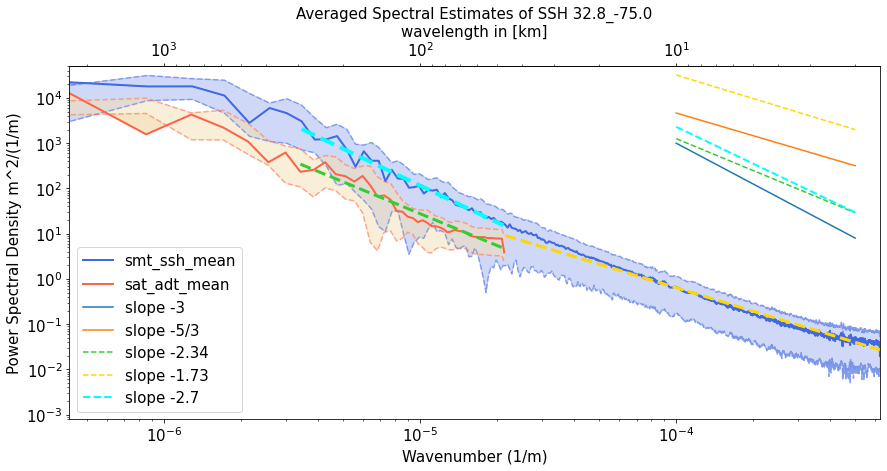

In [12]:
# draw spectral estimates
section = '32.8_-75.0'
k = 2

[A_smt, f_smt, dm_smt, A_smt_mean, std_smt] = np.load(f'data/smt_sections/data_smt_{section}.npy',allow_pickle=True)
[A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load(f'data/satellite_sections/5_1/data_sat_{section}.npy',allow_pickle=True)

# calc standard error of the mean
#std_sat = scipy.stats.sem(A_sat, axis=0, ddof=1, nan_policy='propagate')
#std_sat = std_sat/(n)
#std_smt = scipy.stats.sem(A_smt, axis=0, ddof=1, nan_policy='propagate')

plot_spatial_spectra(A_smt_mean, std_smt, A_sat_mean, std_sat, k, section)



## 5_1 calc mean of different slices


In [76]:
AA = np.zeros((5,A_smt_mean.size))
BB = np.zeros((5,A_sat_mean.size))
sections = '32.8_-75.0', '31.8_-75.0','30.8_-75.0', '29.8_-75.0','28.8_-75.0'
for ii in np.arange(5):
    section = sections[ii]
    [A_smt, f_smt, dm_smt, A_smt_mean, std_smt] = np.load(f'data/smt_sections/data_smt_{section}.npy',allow_pickle=True)
    AA[ii,:] = A_smt_mean
    #satelite
    [A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load(f'data/satellite_sections/data_sat_{section}.npy',allow_pickle=True)
    BB[ii,:] = A_sat_mean

AM = np.mean(AA, axis=0)
AM_std = np.std(AA, axis=0)

BM = np.mean(BB, axis=0)
BM_std = np.std(BB, axis=0)
    

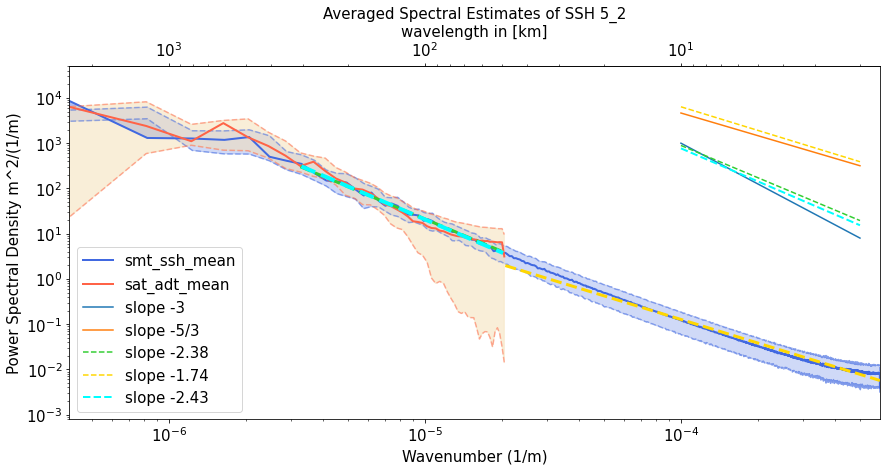

In [15]:
plot_spatial_spectra(AM, AM_std, BM, BM_std, k, '5_2')


## 5 2 calc mean differences

In [35]:
search_str = f'data_sat*.npy' 
path_data = f'data/satellite_sections/10_3/'
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()
sat_sections = flist 
search_str = f'data_smt*.npy' 
path_data = f'data/smt_sections/10_3/'
flist      = np.array(glob.glob(path_data+search_str))
flist.sort()
smt_sections = flist

In [37]:
section

'/work/mh0033/m300878/model_evaluation/data/10_4/data_smt_33.05_-75.0.npy'

In [75]:
f'{section[-14:-4:]}'

'33.8_-75.0'

In [39]:
# draw spectral estimates
k = 2
for ii in np.arange(n):
    section = smt_sections[ii]
    [A_smt, f_smt, dm_smt, A_smt_mean, std_smt] = np.load(f'{section}',allow_pickle=True)
    section = sat_sections[ii]
    [A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load(f'{section}',allow_pickle=True)
    
    name = f'{section[-14:]}'
    
    #plot_spatial_spectra(A_smt_mean, std_smt, A_sat_mean, std_sat, k, name)




In [63]:
n = 10
AA = np.zeros((n,A_smt_mean.size))
BB = np.zeros((n,A_sat_mean.size))

for ii in np.arange(n):
    section = smt_sections[ii]
    [A_smt, f_smt, dm_smt, A_smt_mean, std_smt] = np.load(f'{section}',allow_pickle=True)
    AA[ii,:] = A_smt_mean
    #satelite
    section = sat_sections[ii]
    [A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load(f'{section}',allow_pickle=True)
    BB[ii,:] = A_sat_mean

AM = np.mean(AA, axis=0)
AM_std = np.std(AA, axis=0)

BM = np.mean(BB, axis=0)
BM_std = np.std(BB, axis=0)
    

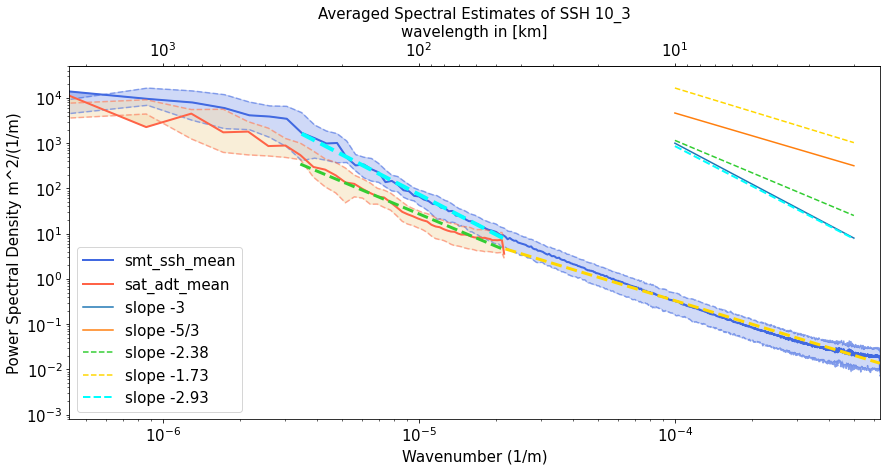

In [64]:
plot_spatial_spectra(AM, AM_std, BM, BM_std, k, '10_3')

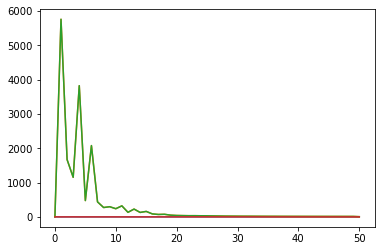

In [33]:
plt.plot(std_sat)
plt.plot(A_sat_mean)
plt.plot(A_sat_mean + A_sat_mean* std_sat/A_sat_mean)
plt.plot(A_sat_mean* std_sat/A_sat_mean)

(0.0008, 50000.0)

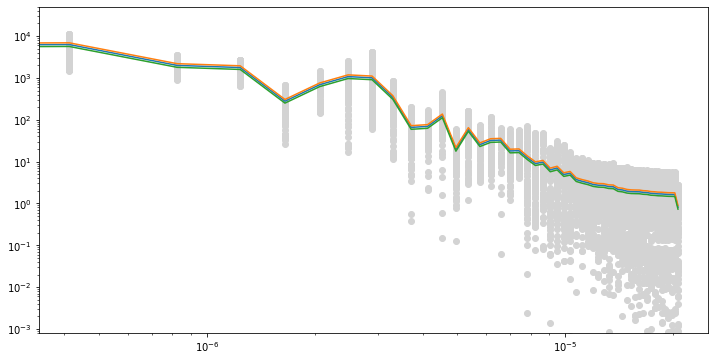

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.loglog(f_sat, A_sat_mean)
plt.loglog(f_sat, A_sat_mean * 1.1)
plt.loglog(f_sat, A_sat_mean *0.9)
for ii in np.arange(90):
    plt.scatter(f_sat, A_sat[ii,:], color='lightgrey')

ax.set_ylim(8e-4, 5e4)

(-50.0, 2000.0)

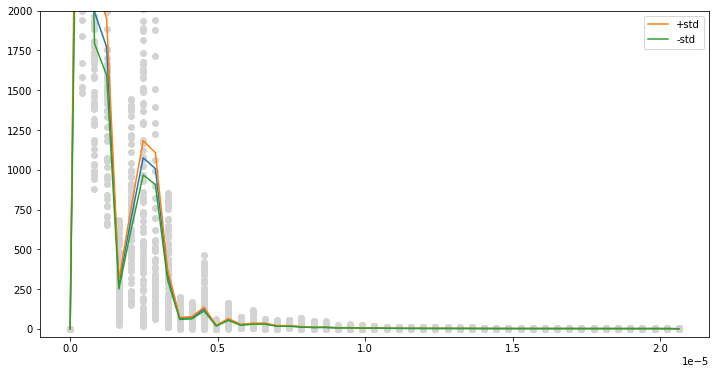

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.plot(f_sat, A_sat_mean)
plt.plot(f_sat, A_sat_mean *1.1, label='+std')
plt.plot(f_sat, A_sat_mean *0.9, label='-std')
for ii in np.arange(90):
    plt.scatter(f_sat, A_sat[ii,:], color='lightgrey')

plt.legend()
ax.set_ylim(-50, 2000)

In [52]:
        npoints =2900
        path_scratch  = f'/scratch/m/m300878/slices/'
        path_ckdtree  = path_scratch # where grid is stored
        sec_name      = f'SMT_nps{npoints}_{int(np.abs(lon[1]))}W{int(lat[1])}N_{int(np.abs(lon[0]))}W{int(lat[1])}N.npz'

        a = f'{path_dat}data_smt_{Lat[kk,0]}_{Lon[kk,0]}'
        if Path(a).is_file():
            print('True')

NameError: name 'Lat' is not defined

In [44]:
from pathlib import Path

In [46]:
path_scratch + sec_name

'/scratch/m/m300878/slices/SMT_nps2900_20W60N_90W60N.npz'

In [47]:
sec_name

'SMT_nps2900_20W60N_90W60N.npz'

In [62]:

       
        kk = 1
        lat = Lat[kk,:]
        lon = Lon[kk,:]

        ##############################################################
        ######## calculate nearest neighbour of section
        npoints = 2900
        sname         = 'A'
        tgname        = 'SMT'
        gname         = 'OceanOnly_SubmesoNA_2500m_srtm30'
        path_tgrid    = f'/pool/data/ICON/oes/grids/OceanOnly/'
        fname_tgrid   = f'{gname}.nc'
        path_scratch  = f'/scratch/m/m300878/slices/'
        path_ckdtree  = path_scratch # where grid is stored
        sec_name      = f'SMT_nps{npoints}_{int(np.abs(lon[1]))}W{int(lat[1])}N_{int(np.abs(lon[0]))}W{int(lat[1])}N.nc'
        #sec_name = f'{path_scratch}data_smt_{Lat[kk,0]}_{Lon[kk,0]}.nc'
        print(sec_name)
        sec_path = path_ckdtree + sec_name

SMT_nps2900_50W33N_75W33N.nc


In [60]:
# select region
lon1 = -75, - 50
#lati = 24.8, 25.2
#lati = 29.8, 30.2

lati = 33.8, 34.2
lati = lati - np.ones(2)
n = 10
Lat = np.zeros((n, 2))
Lon = np.zeros((n, 2))
for ii in np.arange(n):
    lati += np.ones(2)*0.25 #0.5
    Lat[ii,:] = lati
    Lon[ii,:] = lon1

In [63]:
sec_path

'/scratch/m/m300878/slices/SMT_nps2900_50W33N_75W33N.nc'

In [67]:
data = xr.open_dataset(sec_path)

In [68]:
data

<xarray.Dataset>
Dimensions:     (isec: 2900)
Dimensions without coordinates: isec
Data variables:
    lon_sec     (isec) float64 ...
    lat_sec     (isec) float64 ...
    dist_sec    (isec) float64 ...
    dckdtree_c  (isec) float64 ...
    ickdtree_c  (isec) int64 ...

In [91]:
section = sat_sections[1]

In [93]:
f'{section[-15:-4:]}'

'_29.8_-75.0'

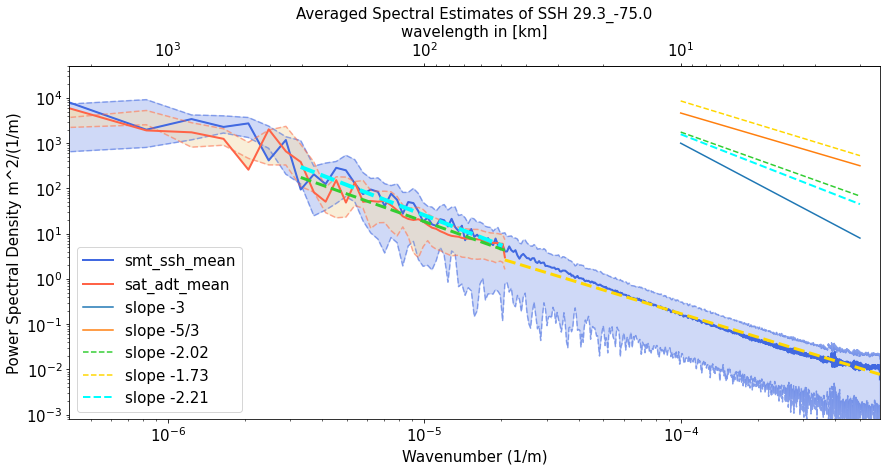

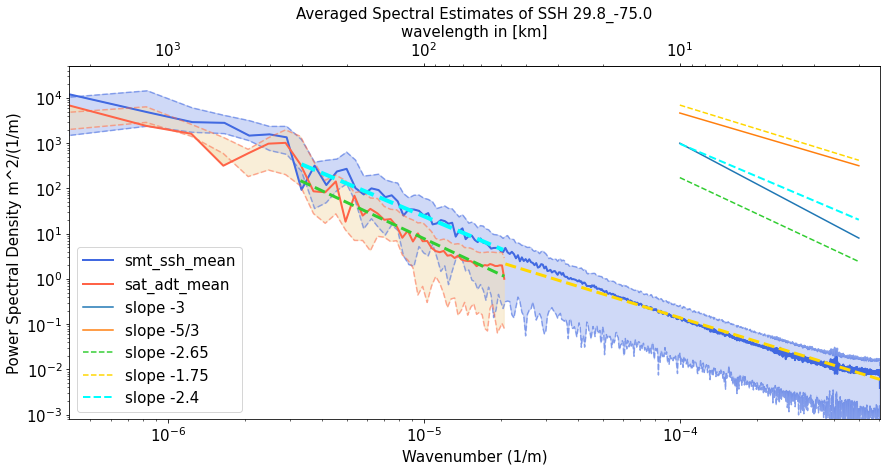

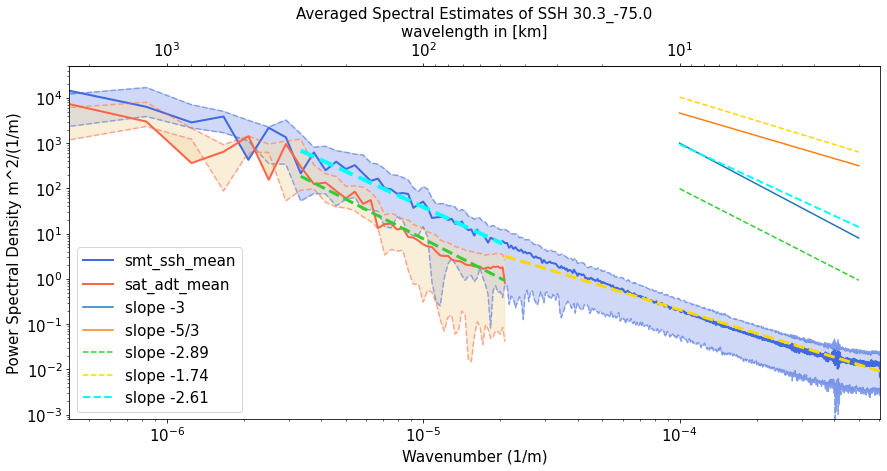

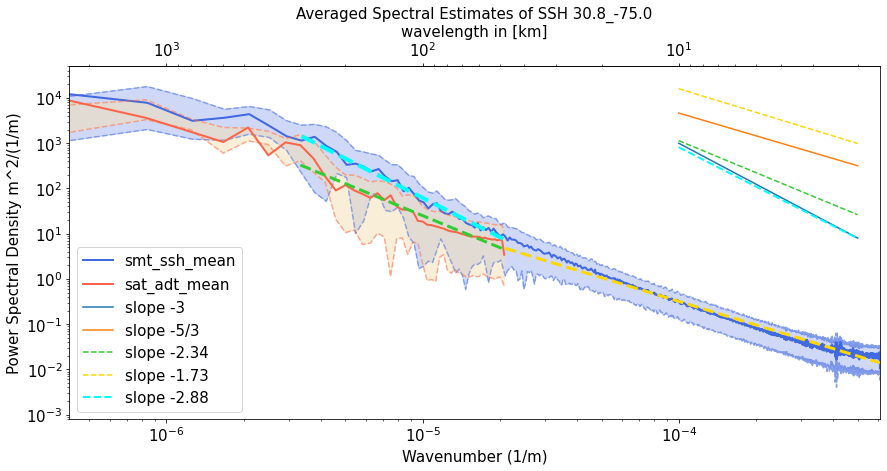

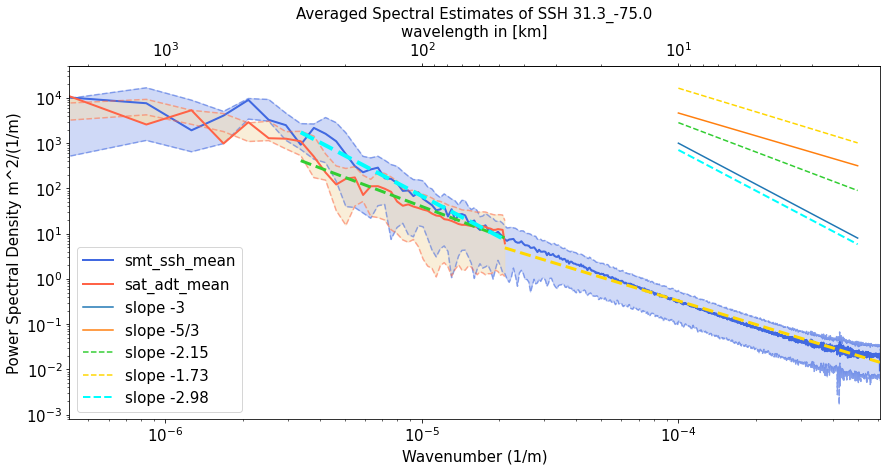

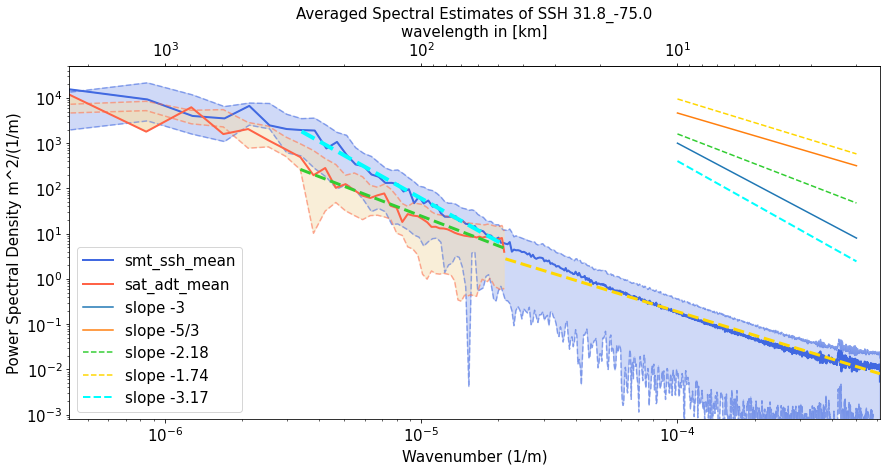

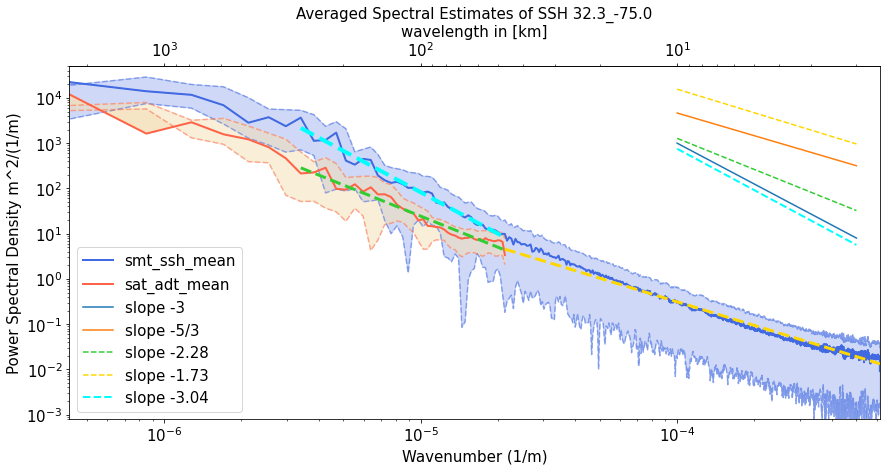

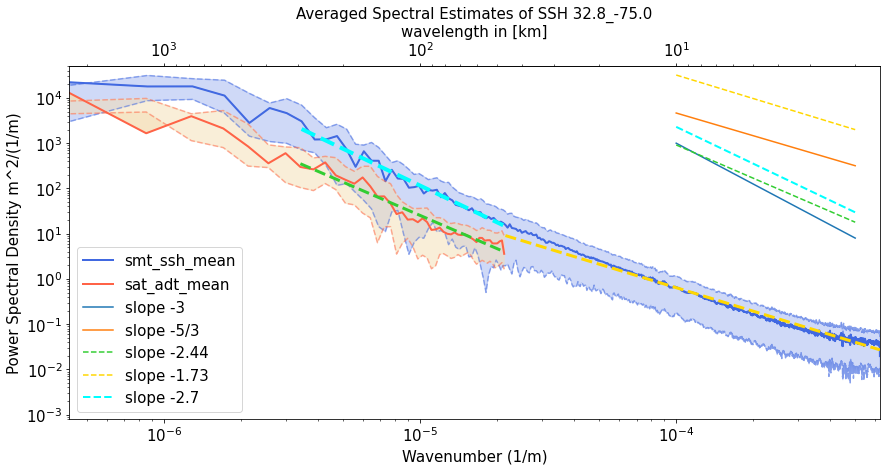

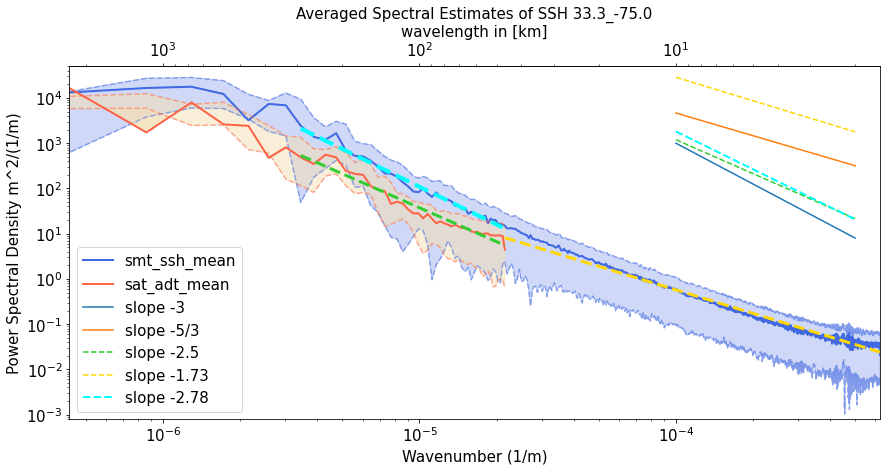

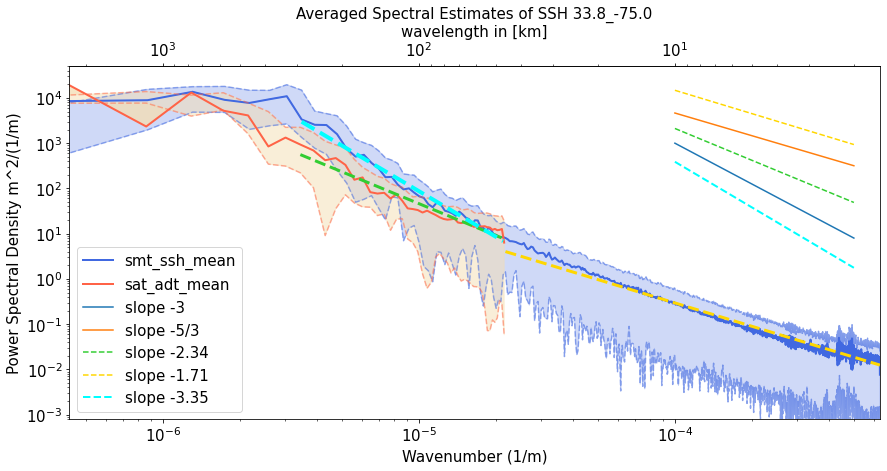

In [78]:
k = 2 
for ii in np.arange(n):
    section = smt_sections[ii]
    [A_smt, f_smt, dm_smt, A_smt_mean, std_smt] = np.load(f'{section}',allow_pickle=True)
    section = sat_sections[ii]
    [A_sat, f_sat, dm_sat, A_sat_mean, std_sat] = np.load(f'{section}',allow_pickle=True)   
    path_save_name = f'{path_imag}ssh_sec_{section[-14:-4:]}'  
    figname = f'{section[-14:-4:]}' 
    plot_spatial_spectra(A_smt_mean, std_smt, f_smt, A_sat_mean, std_sat, f_sat, k, figname, path_save_name)

In [77]:
def plot_spatial_spectra(A_smt_mean, std_smt, f_smt, A_sat_mean, std_sat, f_sat, k, figname, path_save_name):
    powerlaw = lambda x, amp, index: amp * (x**index)
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    #l=2.5

    # smt
    kernel_size = k
    kernel = np.ones(kernel_size) / kernel_size
    #smean_m_std = A_smt_mean - std_smt #np.abs(A_smt_mean - std_smt)
    smean_m_std = np.abs(A_smt_mean - std_smt)
    smean_m_std = np.convolve(smean_m_std, kernel, mode='same')
    #smean_p_std = A_smt_mean + std_smt#np.abs(A_smt_mean + std_smt)
    smean_p_std = np.abs(A_smt_mean + std_smt)
    smean_p_std = np.convolve(smean_p_std, kernel, mode='same')

    plt.loglog(f_smt, smean_p_std, color='royalblue', linestyle='--',alpha=0.5)
    plt.loglog(f_smt, A_smt_mean, label='smt_ssh_mean', color='royalblue', linewidth=2)
    plt.fill_between(f_smt, A_smt_mean, smean_p_std, color='royalblue', alpha=0.25)
    plt.loglog(f_smt, smean_m_std, linestyle='--',  color='royalblue', alpha=0.5)
    plt.fill_between(f_smt, A_smt_mean, smean_m_std, color='royalblue', alpha=0.25)

    # satellite
    kernel_size = k
    kernel = np.ones(kernel_size) / kernel_size
    mean_m_std = np.abs(A_sat_mean - std_sat)
    mean_m_std = np.convolve(mean_m_std, kernel, mode='same')
    mean_p_std = np.abs(A_sat_mean + std_sat)
    mean_p_std = np.convolve(mean_p_std, kernel, mode='same')

    plt.loglog(f_sat, mean_p_std, color='tomato', linestyle='--', alpha=0.5)
    plt.loglog(f_sat, A_sat_mean, label='sat_adt_mean', color='tomato', linewidth=2)
    plt.fill_between(f_sat, A_sat_mean, mean_p_std, color='wheat', alpha=0.5)
    plt.loglog(f_sat, mean_m_std, linestyle='--',  color='tomato', alpha=0.5)
    plt.fill_between(f_sat, A_sat_mean, mean_m_std, color='wheat', alpha=0.5)

    #####################
    fx = np.linspace(1e-4,5e-4,100)
    pp = 10000
    y2 = pp* 3e-9*np.power(fx, (-2))
    y3 = pp* 1e-13*np.power(fx, (-3))
    y5 = pp* 1e-7*np.power(fx, (-5/3))

    plt.loglog(fx,y3, label='slope -3')
    plt.loglog(fx,y5, label='slope -5/3')

    # slope satellite
    xdata = f_sat[8:]
    ydata = A_sat_mean[8:]
    logx = np.log10(xdata)
    logy = np.log10(ydata)
    res = stats.linregress(logx, logy)
    index = res.slope
    amp = 10**res.intercept
    plt.plot(xdata, powerlaw(xdata, amp, index),linewidth=3, linestyle='dashed', color="limegreen")  
    plt.plot(fx, powerlaw(fx, pp*amp, index), linestyle='dashed', color="limegreen", label=f'slope {index:3.3}') 


    # slope smt
    xdata = f_smt[50:]
    ydata = A_smt_mean[50:]
    logx = np.log10(xdata)
    logy = np.log10(ydata)
    res = stats.linregress(logx, logy)
    index = res.slope
    amp = 10**res.intercept
    plt.plot(xdata, powerlaw(xdata, amp, index),linewidth=3, linestyle='dashed', color="gold")  
    plt.plot(fx, powerlaw(fx, 5*pp*amp, index), linestyle='dashed', color="gold", label=f'slope {index:3.3}') 

    # slope smt
    xdata = f_smt[8:50]
    ydata = A_smt_mean[8:50]
    logx = np.log10(xdata)
    logy = np.log10(ydata)
    res = stats.linregress(logx, logy)
    index = res.slope
    amp = 10**res.intercept
    plt.plot(xdata, powerlaw(xdata, amp, index), linewidth=4, linestyle='--', color="aqua")  
    plt.plot(fx, powerlaw(fx, pp*amp, index), linewidth=2, linestyle='--', color="aqua", label=f'slope {index:3.3}') 

    x = f_smt
    def forward(x):
        return 1 / x / 1000
    def inverse(x):
        return 1 / x 
    secax = ax.secondary_xaxis('top', functions=(forward, inverse))
    secax.set_xlabel('wavelength in [km]', fontsize=15)

    ax.autoscale(enable=True, tight=True)
    ax.set_ylim(8e-4, 5e4)
    #ax.autoscale(enable=True, tight=True)
    #ax.set_xlim(1e-6, 1e10)
    fig.tight_layout()

    plt.legend(fontsize=15, loc='lower left')
    ax.tick_params(labelsize=15)
    secax.tick_params(labelsize=15)
    plt.xlabel('Wavenumber (1/m)', fontsize=15)
    plt.ylabel('Power Spectral Density m^2/(1/m)',fontsize=15)
    plt.title(f'Averaged Spectral Estimates of SSH {figname}',fontsize=15);
    plt.savefig(f'{path_save_name}.png', bbox_inches='tight')

In [103]:
# select region
#lon1 = -75, - 50
lon1 = -50, - 25

#lati = 24.8, 25.2
#lati = 29.8, 30.2
lati = 30.8, 31.8
#lati = 33.8, 34.2
n = 10
Lat = np.zeros((n, 2))
Lon = np.zeros((n, 2))
for ii in np.arange(n):
    Lat[ii,:] = lati
    Lon[ii,:] = lon1
    lati += np.ones(2)*0.25 #0.5